### Getting GPS and UTC time

In [24]:
from datetime import datetime, timedelta

def gps():
    ep = datetime(1980, 1, 6, 0, 0, 0)
    now = datetime.utcnow()
    diff = now - ep
    sec = int(diff.total_seconds())
    ls = 18
    sec += ls
    return sec

g_time = gps()
print("Current GPS time in seconds:", g_time)
g_time

Current GPS time in seconds: 1416486937


/tmp/ipykernel_646409/4206825396.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


1416486937

In [26]:
utc = datetime.utcnow()
sec = time.mktime(utc.timetuple()) + utc.microsecond / 1e6
print("Current UTC time in seconds:", int(sec))


Current UTC time in seconds: 1732431926


/tmp/ipykernel_646409/354495934.py:1: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  utc = datetime.utcnow()


# Computing and Plotting Sensitivity pattern for detectors

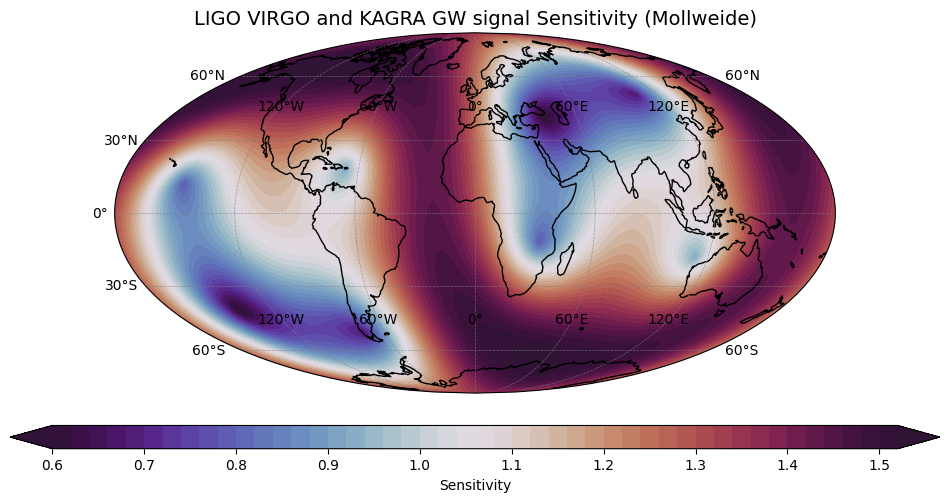

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import lal
from pycbc.detector import Detector
from joblib import Parallel, delayed

ra = np.linspace(0, 2 * np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 180)
# t = lal.LIGOTimeGPS(time.time())
t=1732431926

def calc_sens(det_name, ra, dec, t):
    det = Detector(det_name)
    sens = np.zeros((len(dec), len(ra)))
    for i, r in enumerate(ra):
        for j, d in enumerate(dec):
            Fp, Fc = det.antenna_pattern(r, d, 0, t)
            sens[j, i] = np.sqrt(Fp**2 + Fc**2)
    return sens

det_names = ['H1','L1','V1','K1']
res = Parallel(n_jobs=-1)(delayed(calc_sens)(name, ra, dec, t) for name in det_names)
sens_map = np.sum(res, axis=0)
lats = np.degrees(dec)
longs = np.degrees(ra)

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Mollweide())
lg, lt = np.meshgrid(longs, lats)
ctr = ax.contourf(lg, lt, sens_map, levels=50, cmap='twilight_shifted', transform=ccrs.PlateCarree(), extend='both')
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
cbar = plt.colorbar(ctr, orientation='horizontal', pad=0.07, aspect=40, label='Sensitivity')
plt.title("LIGO Hanford, Livingstone,Virgo and KAGRA GW signal Sensitivity (Mollweide)", fontsize=14)
plt.savefig('H1_L1_V1_K1_current.pdf', dpi=300)
plt.show()


In [14]:
from pycbc.detector import Detector
from astropy.utils import iers

# Make sure the documentation can be built without an internet connection
iers.conf.auto_download = True

# The source of the gravitational waves
right_ascension = 0.7
declination = -0.5

# Reference location will be the Hanford detector
# see the `time_delay_from_earth_center` method to use use geocentric time
# as the reference
dref = Detector("H1")

# Time in GPS seconds that the GW passes
time = 1187008882.4
# Time that the GW will (or has) passed through the given detector
for ifo in ["H1", "L1", "V1",'K1']:
    d = Detector(ifo)
    dt = d.time_delay_from_detector(dref, right_ascension, declination, time)
    st = "GW passed through {} {} seconds relative to passing by Hanford"
    print(st.format(ifo, dt))

GW passed through H1 -0.0 seconds relative to passing by Hanford
GW passed through L1 -0.0038603530539411926 seconds relative to passing by Hanford
GW passed through V1 0.020611471150689557 seconds relative to passing by Hanford
GW passed through K1 0.015788720826245457 seconds relative to passing by Hanford


In [15]:
import time
import lal

t = lal.LIGOTimeGPS(time.time())
print(t)


1732446666.937399626


# Creating animation

/tmp/ipykernel_309613/214185251.py:5: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
Computing sensitivity maps: 100%|██████████| 144/144 [06:39<00:00,  2.77s/it]
/tmp/ipykernel_309613/214185251.py:60: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  return ctr.collections
/tmp/ipykernel_309613/214185251.py:60: MatplotlibDeprecatio

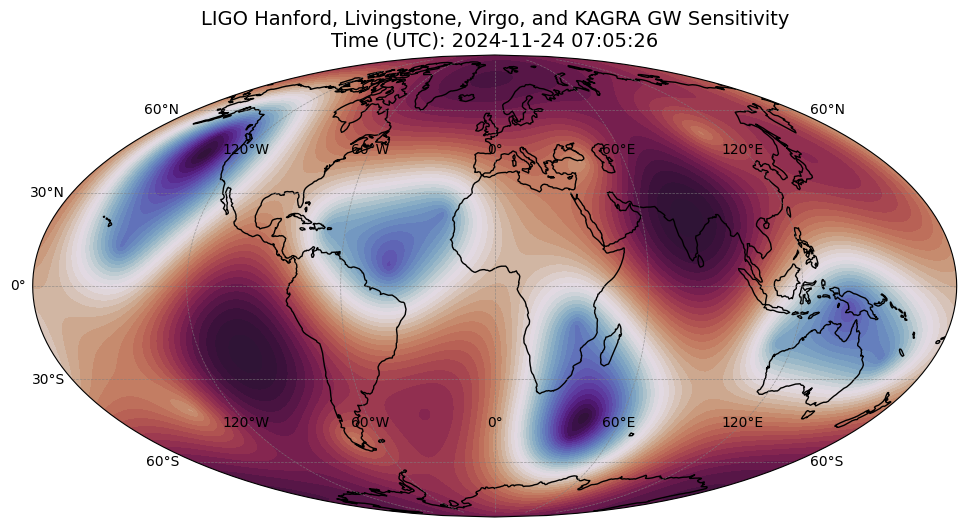

In [ ]:
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

ra = np.linspace(0, 2 * np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 180)
t0 = 1732431926
times = t0 + np.arange(0, 24*3600, 600)

def c_sens(dname, ra, dec, t):
    det = Detector(dname)
    sens = np.zeros((len(dec), len(ra)))
    for i, r in enumerate(ra):
        for j, d in enumerate(dec):
            Fp, Fc = det.antenna_pattern(r, d, 0, t)
            sens[j, i] = np.sqrt(Fp**2 + Fc**2)
    return sens

dnames = ['H1', 'L1', 'V1', 'K1']

s_maps = []
for t in tqdm(times, desc="Computing sensitivity maps"):
    res = Parallel(n_jobs=-1)(delayed(c_sens)(name, ra, dec, t) for name in dnames)
    s_map = np.sum(res, axis=0)
    s_maps.append(s_map)

lats = np.degrees(dec)
longs = np.degrees(ra)
lg, lt = np.meshgrid(longs, lats)

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ctr = None

def upd(frm):
    global ctr
    s_map = s_maps[frm]
    t_lab = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(times[frm]))
    ax.clear()
    ctr = ax.contourf(lg, lt, s_map, levels=50, cmap='twilight_shifted',
                      transform=ccrs.PlateCarree(), extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                      alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    plt.title(f"LIGO Hanford, Livingstone, Virgo, and KAGRA GW Sensitivity\nTime (UTC): {t_lab}", fontsize=14)
    return ctr.collections

ani = FuncAnimation(fig, upd, frames=len(times), blit=False)
ani.save('sensitivity_animation.mp4', fps=10, dpi=300)
